# Gradient Estimation in Stochastic Computation Graphs

Our objective here is to compare the implementations of Gradient Estimation in **Numpy**, **TensorFlow with likelihood-ratio** and **TensorFlow with full Algorithmic-Differentiation** (AD).

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import utils

%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Example 1 - Single path, uni-dimensional

![scg1](files/img/scg1.png)

$$
\begin{align}
\theta &\in [-\infty, +\infty] \\
x(\theta) &= \text{sigmoid}(\theta) = \frac{1}{1+e^{-\theta}} \\
y &\sim \mathcal{N}(\mu=x + 0.5, \sigma=0.1) \\
f(y) &= y(y - 2) \\
\end{align}
$$

$$
\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{y~\sim~p(\cdot~|~x(\theta))} [ f(y) ]
\end{equation}
$$

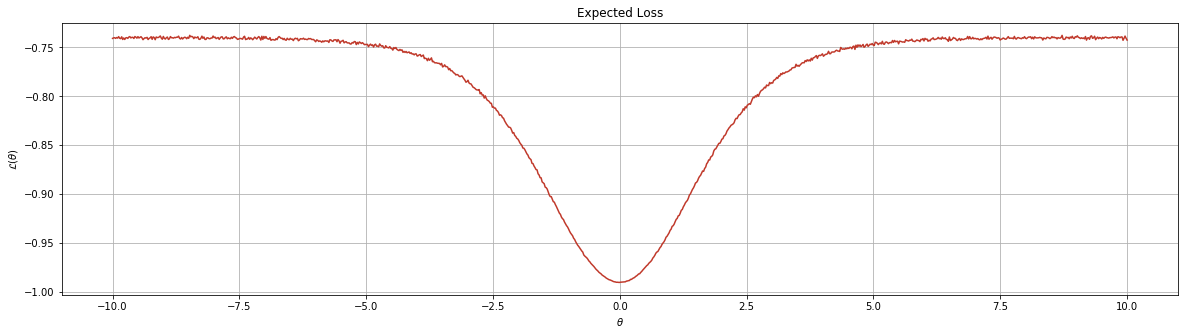

In [2]:
thetas = np.linspace(-10.0, 10.0, 1000)

losses = []
for theta in thetas:
    x = 1 / (1 + np.exp(-theta))
    mu = x + 0.5
    sigma = 0.1
    y = np.random.normal(loc=mu, scale=sigma, size=(10000,))
    f = y * (y - 2)
    loss = np.mean(f)
    losses.append(loss)

utils.plot_expected_loss(thetas, losses)

### Hyper-parameters

In [3]:
learning_rate = 0.1
batch_size = 100000
epochs = 500
theta_init = -1.0

### Gradient Estimation in Numpy

In [4]:
def forward(inputs, batch_size):
    theta = inputs
    x = 1 / (1 + np.exp(-theta))
    mu = x + 0.5
    sigma = 0.1
    y = np.random.normal(loc=mu, scale=sigma, size=(batch_size,))
    f = y * (y - 2)
    loss = np.mean(f)
    cache = {
        'x': x,
        'mu': mu,
        'sigma': sigma,
        'y': y,
        'f': f
    }
    return loss, cache

In [5]:
def backward(cache):
    f, y, mu, sigma, x = cache['f'], cache['y'], cache['mu'], cache['sigma'], cache['x']
    grad_log_mu = (y - mu) / np.square(sigma)
    grad_mu_x = 1.0
    grad_x_theta = x * (1 - x)
    grad_log_theta = grad_log_mu * grad_mu_x * grad_x_theta
    grad_loss_theta = np.mean(f * grad_log_theta)
    return grad_loss_theta

In [6]:
def SGD(epochs, learning_rate, theta_init, batch_size):
    theta = theta_init
    losses = []
    grads = []
    thetas = [theta_init]
    for epoch in range(epochs):
        loss, cache = forward(theta, batch_size)
        grad_loss_theta = backward(cache)
        theta = theta - learning_rate * grad_loss_theta
        losses.append(loss)
        grads.append(grad_loss_theta)
        thetas.append(theta)
        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta, loss, grad_loss_theta), end='')
    return losses, grads, thetas

In [7]:
losses, grads, thetas = SGD(epochs, learning_rate, theta_init, batch_size)

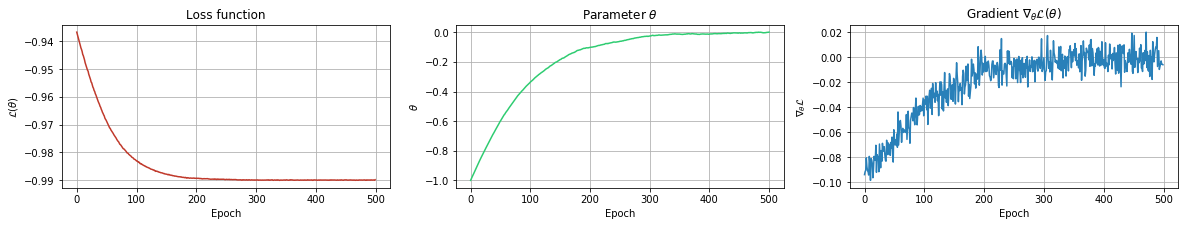

In [8]:
utils.plot_results(losses, thetas, grads)

### Gradient Estimation in TensorFlow (with likelihood ratio)

In [9]:
graph = tf.Graph()
with graph.as_default():

    # model
    theta = tf.Variable(initial_value=theta_init, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, dtype=tf.float32, name="sigma")
    p_y = tf.distributions.Normal(loc=mu, scale=sigma, name='p_y')
    y = p_y.sample(sample_shape=(batch_size), name="y")

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # gradient estimate
    log_prob = p_y.log_prob(y, name="log_prob")
    grad_log_theta, = tf.gradients(xs=theta, ys=(f * log_prob), stop_gradients=[y])
    grad_loss_theta = tf.divide(grad_log_theta, tf.cast(batch_size, tf.float32), name="grad_theta")

    # stochastic gradient descent
    new_theta = theta.assign(theta - learning_rate * grad_loss_theta)

In [10]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())
    
    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate model
        loss_, grad_loss_theta_, theta_ = sess.run([loss, grad_loss_theta, theta])

        # optimize parameter
        sess.run(new_theta)
        
        # store results
        losses.append(loss_)
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta_, loss_, grad_loss_theta_), end='')

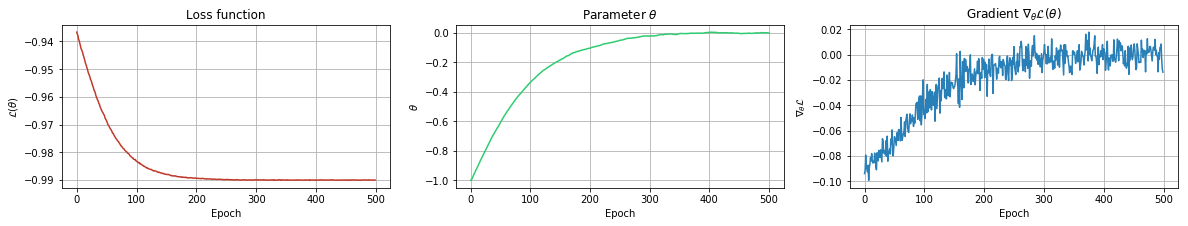

In [11]:
utils.plot_results(losses, thetas, grads)

### Gradient Estimation with TensorFlow (full AD)

In [12]:
graph = tf.Graph()
with graph.as_default():

    theta = tf.Variable(initial_value=theta_init, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, name="sigma")
    y = tf.distributions.Normal(loc=mu, scale=sigma).sample(sample_shape=(batch_size), name="y")

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    train_step = optimizer.apply_gradients(grads_and_vars, name='minimize')

In [13]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate model
        theta_, loss_ = sess.run([theta, loss])

        # optimize parameter
        grads_and_vars_ = sess.run(grads_and_vars)
        sess.run(train_step)
        
        # store results
        losses.append(loss_)
        grad_loss_theta_ = grads_and_vars_[0][0]
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta_, loss_, grad_loss_theta_), end='')

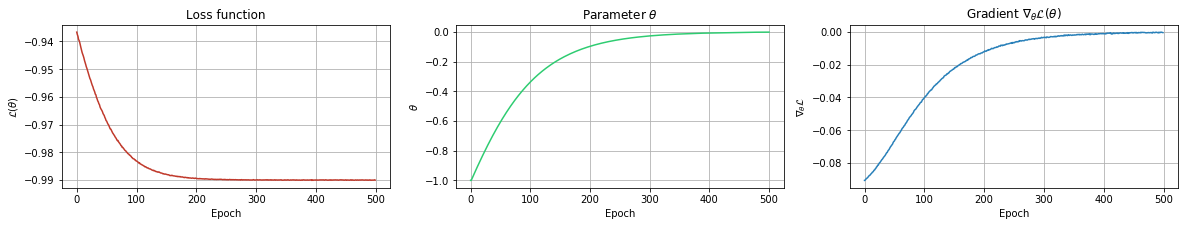

In [14]:
utils.plot_results(losses, thetas, grads)

### Gradient Estimation with TensorFlow (full AD) and Re-parameterization Trick

In [15]:
graph = tf.Graph()
with graph.as_default():

    theta = tf.Variable(initial_value=theta_init, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, name="sigma")
    noise = tf.stop_gradient(tf.distributions.Normal(loc=0.0, scale=1.0).sample(sample_shape=(batch_size), name="noise"))
    y = mu + sigma * noise

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    train_step = optimizer.apply_gradients(grads_and_vars, name='minimize')

In [16]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate model
        theta_, loss_ = sess.run([theta, loss])

        # optimize parameter
        grads_and_vars_ = sess.run(grads_and_vars)
        sess.run(train_step)
        
        # store results
        losses.append(loss_)
        grad_loss_theta_ = grads_and_vars_[0][0]
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta_, loss_, grad_loss_theta_), end='')

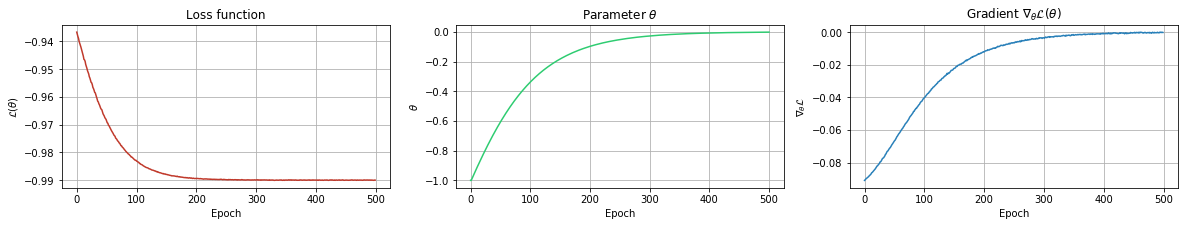

In [17]:
utils.plot_results(losses, thetas, grads)

## Example 2 - Multiple paths, uni-dimensional

<img src="files/img/scg4.png">

$$
\begin{align}
\theta &\in [-\infty, +\infty] \\
x(\theta) &= \text{sigmoid}(\theta) = \frac{1}{1+e^{-\theta}} \\
z(\theta) &= \theta^2~e^{-\theta^2}\\
y &\sim \mathcal{N}(\mu=x + 0.5, \sigma=0.1) \\
f(y) &= y(y - 2) + \frac{z}{2}\\
\end{align}
$$

$$
\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{y \sim p(\cdot|x(\theta))} [f(y, z(\theta))]
\end{equation}
$$

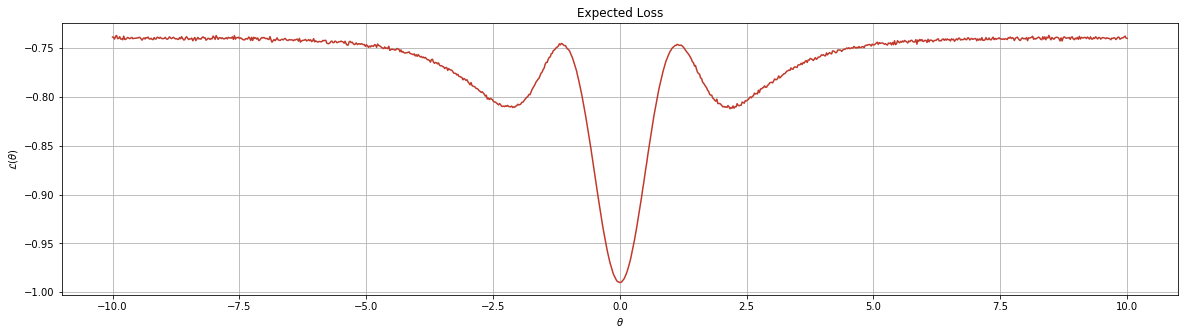

In [18]:
thetas = np.linspace(-10.0, 10.0, 1000)

losses = []
for theta in thetas:
    x = 1 / (1 + np.exp(-theta))
    mu = x + 0.5
    sigma = 0.1
    y = np.random.normal(loc=mu, scale=sigma, size=(10000,))
    z = (theta**2) * np.exp(-theta**2)
    f = y * (y - 2) + z/2
    loss = np.mean(f)
    losses.append(loss)

utils.plot_expected_loss(thetas, losses)

### Hyper-parameters

In [19]:
learning_rate = 0.1
batch_size = 1000000
epochs = 100
theta_init = -1.0

### Gradient Estimation in Numpy

In [20]:
def forward(inputs, batch_size):
    theta = inputs
    x = 1 / (1 + np.exp(-theta))
    mu = x + 0.5
    sigma = 0.1
    y = np.random.normal(loc=mu, scale=sigma, size=(batch_size,))
    z = (theta**2) * np.exp(-theta**2)
    f = y * (y - 2) + z / 2
    loss = np.mean(f)
    cache = {
        'theta': theta,
        'x': x,
        'mu': mu,
        'sigma': sigma,
        'y': y,
        'z': z,
        'f': f
    }
    return loss, cache

In [21]:
def backward(cache):
    f, z, y, mu, sigma, x, theta = cache['f'], cache['z'], cache['y'], cache['mu'], cache['sigma'], cache['x'], cache['theta']

    grad_log_mu = (y - mu) / np.square(sigma)
    grad_mu_x = 1.0
    grad_x_theta = x * (1 - x)
    grad_log_theta = grad_log_mu * grad_mu_x * grad_x_theta

    grad_f_z = 1/2
    grad_z_theta = 2 * theta * np.exp(- theta ** 2) * (1 - theta ** 2)
    grad_f_theta = grad_f_z * grad_z_theta

    grad_loss_theta = np.mean(f * grad_log_theta + grad_f_theta)

    return grad_loss_theta

In [22]:
def SGD(epochs, learning_rate, theta_init, batch_size):
    theta = theta_init
    losses = []
    grads = []
    thetas = [theta_init]
    for epoch in range(epochs):
        loss, cache = forward(theta, batch_size)
        grad_loss_theta = backward(cache)
        theta = theta - learning_rate * grad_loss_theta
        losses.append(loss)
        grads.append(grad_loss_theta)
        thetas.append(theta)
        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta, loss, grad_loss_theta), end='')
    return losses, grads, thetas

In [23]:
losses, grads, thetas = SGD(epochs, learning_rate, theta_init, batch_size)

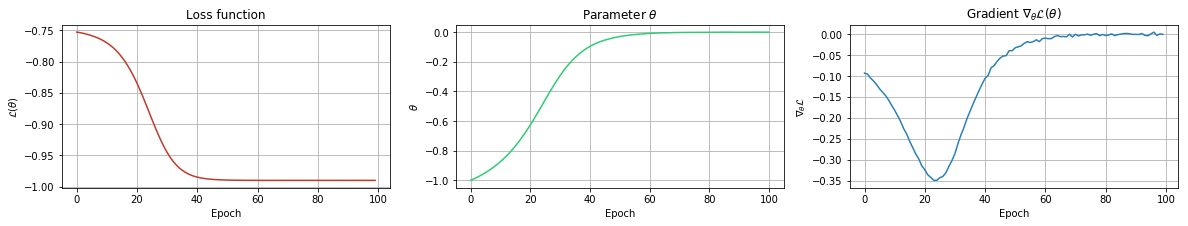

In [24]:
utils.plot_results(losses, thetas, grads)

### Gradient Estimation in TensorFlow (with likelihood ratio)

In [25]:
graph = tf.Graph()
with graph.as_default():

    # model
    theta = tf.Variable(initial_value=theta_init, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, dtype=tf.float32, name="sigma")
    p_y = tf.distributions.Normal(loc=mu, scale=sigma, name='p_y')
    y = p_y.sample(sample_shape=(batch_size), name="y")

    z = tf.multiply(theta ** 2, tf.exp(- theta ** 2), name='z')
    
    f = tf.add(y * (y - 2), z / 2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # gradient estimate
    log_prob = p_y.log_prob(y, name="log_prob")
    grad_log_theta, = tf.gradients(xs=theta, ys=(f * log_prob), stop_gradients=[y, z])

    grad_f_theta, = tf.gradients(xs=theta, ys=f, stop_gradients=[y])
    grad_loss_theta = tf.divide(grad_log_theta + grad_f_theta, tf.cast(batch_size, tf.float32), name="grad_theta")

    # stochastic gradient descent
    new_theta = theta.assign(theta - learning_rate * grad_loss_theta)

In [26]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())
    
    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate model
        loss_, grad_loss_theta_, theta_ = sess.run([loss, grad_loss_theta, theta])

        # optimize parameter
        sess.run(new_theta)
        
        # store results
        losses.append(loss_)
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta_, loss_, grad_loss_theta_), end='')

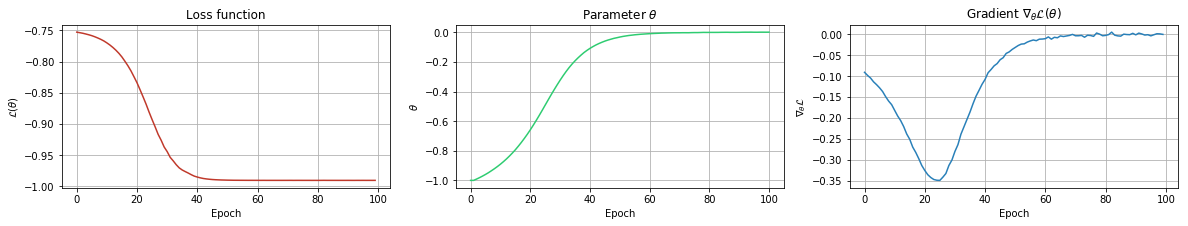

In [27]:
utils.plot_results(losses, thetas, grads)

### Gradient Estimation with TensorFlow (full AD)

In [28]:
graph = tf.Graph()
with graph.as_default():

    theta = tf.Variable(initial_value=theta_init, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, name="sigma")
    y = tf.distributions.Normal(loc=mu, scale=sigma).sample(sample_shape=(batch_size), name="y")

    z = tf.multiply(theta ** 2, tf.exp(- theta ** 2), name='z')

    f = tf.add(y * (y - 2), z / 2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    train_step = optimizer.apply_gradients(grads_and_vars, name='minimize')

In [29]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate model
        theta_, loss_ = sess.run([theta, loss])

        # optimize parameter
        grads_and_vars_ = sess.run(grads_and_vars)
        sess.run(train_step)
        
        # store results
        losses.append(loss_)
        grad_loss_theta_ = grads_and_vars_[0][0]
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta_, loss_, grad_loss_theta_), end='')

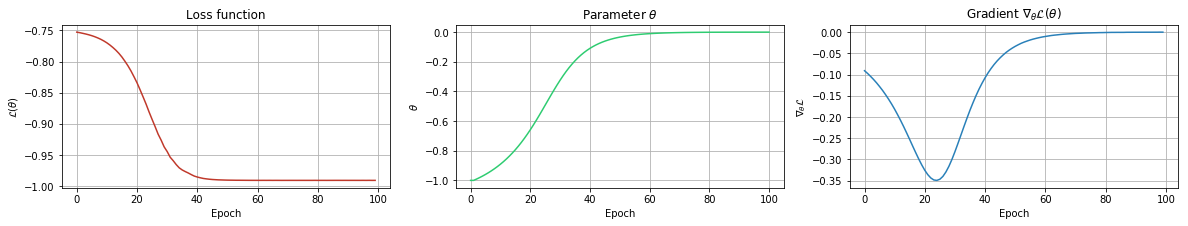

In [30]:
utils.plot_results(losses, thetas, grads)

### Gradient Estimation with TensorFlow (full AD) and Re-parameterization Trick

In [31]:
graph = tf.Graph()
with graph.as_default():

    theta = tf.Variable(initial_value=theta_init, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, name="sigma")
    noise = tf.stop_gradient(tf.distributions.Normal(loc=0.0, scale=1.0).sample(sample_shape=(batch_size), name="noise"))
    y = mu + sigma * noise

    z = tf.multiply(theta ** 2, tf.exp(- theta ** 2), name='z')

    f = tf.add(y * (y - 2), z / 2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    train_step = optimizer.apply_gradients(grads_and_vars, name='minimize')

In [32]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate model
        theta_, loss_ = sess.run([theta, loss])

        # optimize parameter
        grads_and_vars_ = sess.run(grads_and_vars)
        sess.run(train_step)
        
        # store results
        losses.append(loss_)
        grad_loss_theta_ = grads_and_vars_[0][0]
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta_, loss_, grad_loss_theta_), end='')

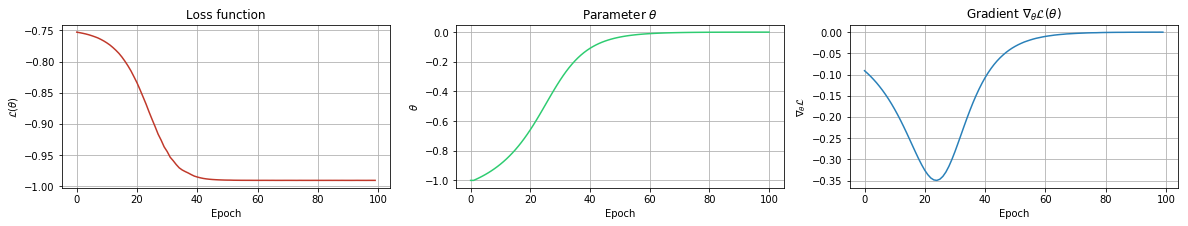

In [33]:
utils.plot_results(losses, thetas, grads)

## Example 3 - Single path, multi-dimensional

<img src="files/img/scg5.png">

$$
\begin{align}
\theta, w& \in \mathbb{R}^n \\
\theta' &= w^{\top} \theta \\
x(\theta') &= \text{sigmoid}(\theta') = \frac{1}{1+e^{-\theta'}} \\
y &\sim \mathcal{N}(\mu=x + 0.5, \sigma=0.1) \\
f(y) &= y(y - 2)\\
\end{align}
$$

$$
\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{y \sim p(\cdot|x(\theta'))} [f(y)]
\end{equation}
$$

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

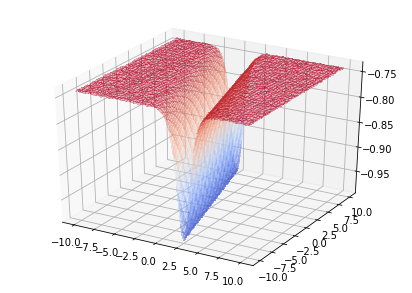

In [35]:
thetas_1 = np.linspace(-10.0, 10.0, 100)
thetas_2 = np.linspace(-10.0, 10.0, 100)
thetas_1, thetas_2 = np.meshgrid(thetas_1, thetas_1)

w = np.array([2, 0.5], dtype=np.float32)
thetas = w[0] * thetas_1 + w[1] * thetas_2
x = 1 / (1 + np.exp(-thetas))

losses = np.ndarray(shape=(thetas.shape), dtype=np.float32)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x_ = x[i][j]
        mu = x_ + 0.5
        sigma = 0.1
        y = np.random.normal(loc=mu, scale=sigma, size=(10000,))
        f = y * (y - 2)
        loss = np.mean(f)
        losses[i][j] = loss

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(thetas_1, thetas_2, losses, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.3)
plt.show()

### Hyper-parameters

In [45]:
learning_rate = 0.1
batch_size = 10000
epochs = 200
theta_init = np.reshape(np.array([-1.0, -1.0], dtype=np.float32), (2, 1))

### Gradient Estimation in Numpy

In [46]:
def forward(inputs, batch_size):
    theta = inputs
    w = np.reshape(np.array([2, 0.5], dtype=np.float32), (1, 2))
    theta_prime = np.dot(w, theta)[0][0]
    x = 1 / (1 + np.exp(-theta_prime))
    mu = x + 0.5
    sigma = 0.1
    y = np.random.normal(loc=mu, scale=sigma, size=(batch_size,))
    f = y * (y - 2)
    loss = np.mean(f)
    cache = {
        'theta': theta,
        'w': w,
        'x': x,
        'mu': mu,
        'sigma': sigma,
        'y': y,
        'f': f
    }
    return loss, cache

In [47]:
def backward(cache):
    w, f, y, mu, sigma, x = cache['w'], cache['f'], cache['y'], cache['mu'], cache['sigma'], cache['x']
    grad_log_mu = (y - mu) / np.square(sigma)
    grad_mu_x = 1.0
    grad_x_theta_prime = x * (1 - x)
    grad_theta_prime_theta = np.transpose(w)
    grad_log_theta = grad_log_mu * grad_mu_x * grad_x_theta_prime * grad_theta_prime_theta
    grad_loss_theta = np.mean(f * grad_log_theta, axis=1, keepdims=True)
    return grad_loss_theta

In [48]:
def SGD(epochs, learning_rate, theta_init, batch_size):
    theta = theta_init
    losses = []
    thetas = []
    grads = []
    for epoch in range(epochs):
        loss, cache = forward(theta, batch_size)
        grad_loss_theta = backward(cache)
        norm_grad = np.sqrt(np.sum(np.square(grad_loss_theta)))
        theta = theta - learning_rate * grad_loss_theta
        losses.append(loss)
        thetas.append(theta)
        grads.append(norm_grad)
        if epoch % 10 == 0:
            print('epoch = {:3d}, loss = {:6f}, |grad| = {:6f}\r'.format(epoch, loss, norm_grad), end='')

    thetas = np.array([
        [theta[0][0] for theta in thetas],
        [theta[1][0] for theta in thetas]
    ])

    return losses, grads, thetas

In [49]:
losses, grads, thetas = SGD(epochs, learning_rate, theta_init, batch_size)

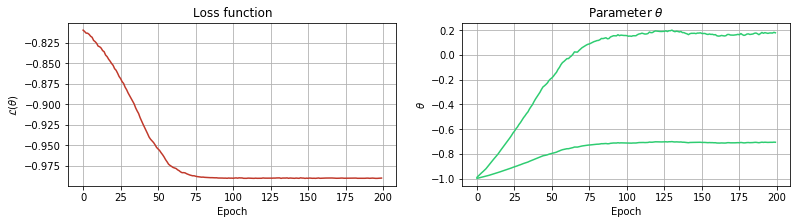

In [50]:
utils.plot_results(losses, thetas)

### Gradient Estimation with TensorFlow (full AD)

In [51]:
graph = tf.Graph()
with graph.as_default():

    theta = tf.Variable(initial_value=theta_init, dtype=tf.float32, name="theta")
    
    w = tf.constant(np.reshape(np.array([2, 0.5], dtype=np.float32), (1, 2)))
    theta_prime = tf.reshape(tf.matmul(w, theta, name="theta_prime"), ())
    
    x = tf.sigmoid(theta_prime, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, name="sigma")
    y = tf.distributions.Normal(loc=mu, scale=sigma).sample(sample_shape=(batch_size), name="y")

    f = tf.multiply(y, y - 2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    train_step = optimizer.apply_gradients(grads_and_vars, name='minimize')

In [52]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate model
        theta_, loss_ = sess.run([theta, loss])

        # optimize parameter
        grads_and_vars_ = sess.run(grads_and_vars)
        sess.run(train_step)
        
        # store results
        losses.append(loss_)
        grad_loss_theta_ = grads_and_vars_[0][0]
        norm_grad = np.sqrt(np.sum(np.square(grad_loss_theta_)))
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, loss = {:6f}, |grad| = {:6f}\r'.format(epoch, loss_, norm_grad), end='')

    thetas = np.array([
        [theta[0][0] for theta in thetas],
        [theta[1][0] for theta in thetas]
    ])

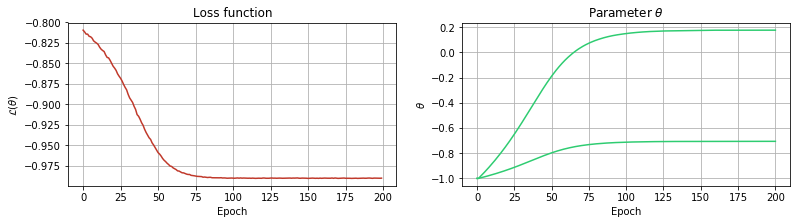

In [53]:
utils.plot_results(losses, thetas)